In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Load dataset
df = pd.read_csv("D:/data_sets/Zomato Dataset.csv")

In [5]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
# Sort by date
df = df.sort_values('Date')

In [7]:
# Use only 'Close' price for prediction
data = df['Close'].values
data = data.reshape(-1, 1)

In [8]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [9]:
# Create training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [10]:
# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 60
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

In [11]:
# Reshape for LSTM input
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [12]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Set early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.0433 - val_loss: 0.0764
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0012 - val_loss: 0.0085
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0015 - val_loss: 0.0056
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/ste

In [13]:
# Make predictions
train_predictions = model.predict(x_train)
test_predictions = model.predict(x_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [14]:
# Invert scaling to get actual values
train_predictions = scaler.inverse_transform(train_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

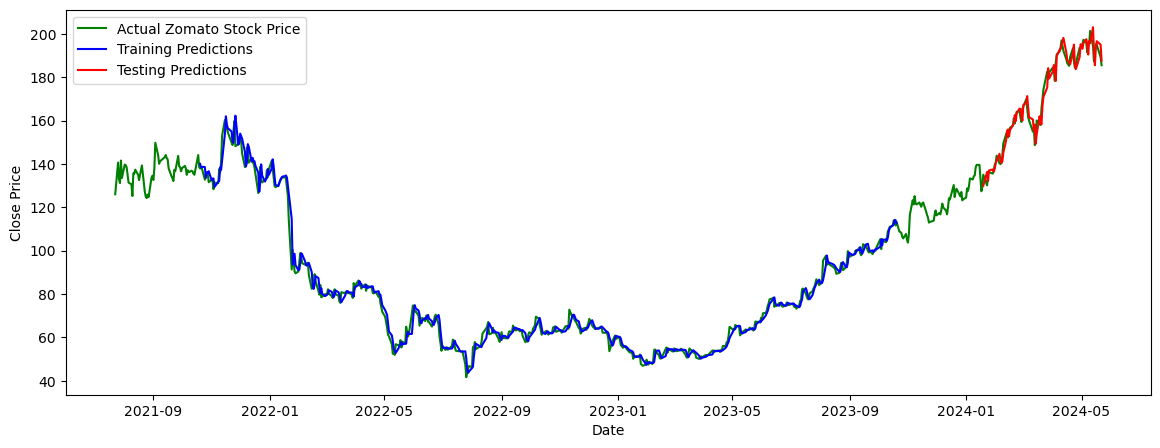

In [15]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], data, color='green', label='Actual Zomato Stock Price')
train_dates = df['Date'][:train_size].values[seq_length:]
test_dates = df['Date'][train_size:].values[seq_length:]
plt.plot(train_dates, train_predictions, color='blue', label='Training Predictions')
plt.plot(test_dates, test_predictions, color='red', label='Testing Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [16]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error

train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))

print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 3.028601554889058
Testing RMSE: 3.8989546963090396
